### **Loading Libraries**

In [1]:
# Custom Modules
from utils.data_loader import load_crime_dataset
from utils.maps import ChicagoMap

# OS modules
from pathlib import Path

# Dependencies
from sodapy import Socrata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import plotly.express as px

# VisualConfiguration
sns.set_theme(style="ticks", color_codes=True)

# Misc
import warnings
warnings.filterwarnings('ignore')

### **Downloading/Locating dataset**

In [2]:
# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
else:
    load_crime_dataset()

File found: chicago-crime-data.csv


### **Loading Dataset**

In [3]:
# Converting result into dataframe
crime_df = pd.read_csv(dataset_path)

# Convert date column to datetime format
crime_df['date'] = pd.to_datetime(crime_df['date'])

print(crime_df.shape)
print(crime_df.columns)
crime_df.head(4)

(1404077, 22)
Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,11662417,JC232642,2019-04-21 12:30:00,009XX E 80TH ST,031A,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,...,8.0,44.0,03,1184044.0,1852159.0,2019,2023-09-14T15:41:59.000,41.749500,-87.601157,"{'latitude': '41.749500329', 'longitude': '-87..."
1,12990873,JG161829,2019-08-17 13:14:00,008XX N KARLOV AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,...,37.0,23.0,17,1148899.0,1905351.0,2019,2023-09-14T15:41:59.000,41.896215,-87.728572,"{'latitude': '41.89621515', 'longitude': '-87...."
2,11630496,JC193727,2019-03-16 11:35:00,045XX N LINCOLN AVE,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,47.0,4.0,06,NaN,NaN,2019,2019-03-23T16:03:16.000,NaN,NaN,NaN
3,11632505,JC196841,2019-03-20 01:00:00,013XX W HOOD AVE,0810,THEFT,OVER $500,OTHER,False,False,...,48.0,77.0,06,NaN,NaN,2019,2019-03-27T16:10:11.000,NaN,NaN,NaN


In [4]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404077 entries, 0 to 1404076
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1404077 non-null  int64         
 1   case_number           1404077 non-null  object        
 2   date                  1404077 non-null  datetime64[ns]
 3   block                 1404077 non-null  object        
 4   iucr                  1404077 non-null  object        
 5   primary_type          1404077 non-null  object        
 6   description           1404077 non-null  object        
 7   location_description  1396526 non-null  object        
 8   arrest                1404077 non-null  bool          
 9   domestic              1404077 non-null  bool          
 10  beat                  1404077 non-null  int64         
 11  district              1404077 non-null  int64         
 12  ward                  1404029 non-null  fl

### **Cleaning Data**

In [5]:
# Dropping redundant columns
crime_df.drop(columns=crime_df.columns[22:], axis = 1, inplace= True)

# Check duplicate rows
print(f"Duplicated rows detected: {sum(crime_df.duplicated())}")

# Check missing values
print(f"Missing Values: {sum(crime_df.isna().sum())}")

Duplicated rows detected: 0
Missing Values: 101772


In [6]:
# Dropping rows with missing values
crime_df.dropna(inplace=True)
crime_df.shape

(1379505, 22)

### **Data**

In [7]:
community_df = pd.read_csv('../assets/maps/comm-areas.csv')
community_df.columns

Index(['the_geom', 'PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID', 'AREA_NUMBE',
       'COMMUNITY', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [8]:
crime_df = crime_df.rename(columns={'community_area': 'community_number'})
community_df = community_df.rename(columns={'AREA_NUM_1': 'community_number','COMMUNITY': 'community_name'})
crime_df = crime_df.merge(community_df[['community_name', 'community_number']], on='community_number', how='left')

In [9]:
# Group by 'primary_type' and calculate arrest statistics
arrest_stats = crime_df.groupby('primary_type').agg(
    total_crimes=('id', 'count'),  # Total crimes per primary_type
    total_arrests=('arrest', lambda x: (x == True).sum())  # Count only True values for arrest
)

# Calculate arrest rate for each primary_type
arrest_stats['arrest_rate_by_primary_type'] = ((arrest_stats['total_arrests'] / arrest_stats['total_crimes']) * 100).round(2)

# Merge the arrest rate back into the original DataFrame
crime_df = crime_df.merge(arrest_stats[['arrest_rate_by_primary_type']], on='primary_type', how='left')

In [10]:
# Group by 'primary_type' and calculate arrest statistics
arrest_stats = crime_df.groupby('community_name').agg(
    total_crimes=('id', 'count'),  # Total crimes per community_name
    total_arrests=('arrest', lambda x: (x == True).sum())  # Count only True values for arrest
)

# Calculate arrest rate for each primary_type
arrest_stats['arrest_rate_by_community'] = ((arrest_stats['total_arrests'] / arrest_stats['total_crimes']) * 100).round(2)

# Merge the arrest rate back into the original DataFrame
crime_df = crime_df.merge(arrest_stats[['arrest_rate_by_community']], on='community_name', how='left')

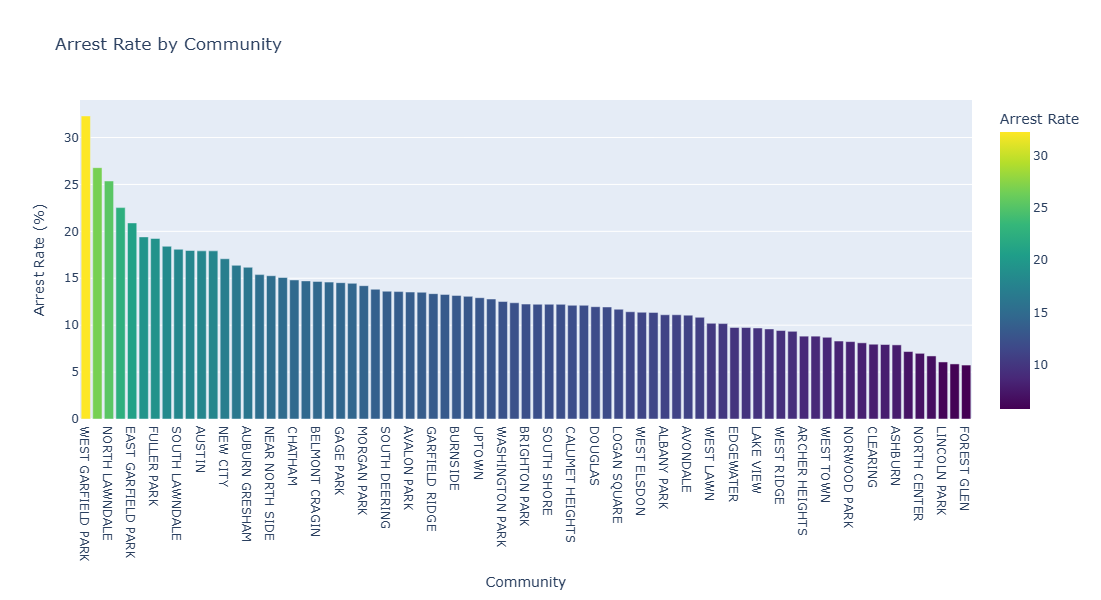

In [31]:
arrest_trend = crime_df.groupby('community_name')['arrest_rate_by_community'].mean().round(2)
arrest_trend = arrest_trend.reset_index()
arrest_trend.columns = ['Community', 'Arrest Rate']

# Create the bar chart
fig = px.bar(
    arrest_trend,
    x='Community',
    y='Arrest Rate',
    title="Arrest Rate by Community",
    labels={'Community': 'Arrest Rate (%)', 'Community': 'Community Name'},
    color='Arrest Rate',  # Color by arrest rate for a gradient effect
    color_continuous_scale='Viridis'   # Choose a color scale (optional)
)

# Update layout for better readability
fig.update_layout(
    xaxis={'categoryorder':'total descending'},  # Sort communities by arrest rate
    xaxis_title="Community",
    yaxis_title="Arrest Rate (%)",
    height=600,
    width=1000
)

# Show the chart
fig.show()

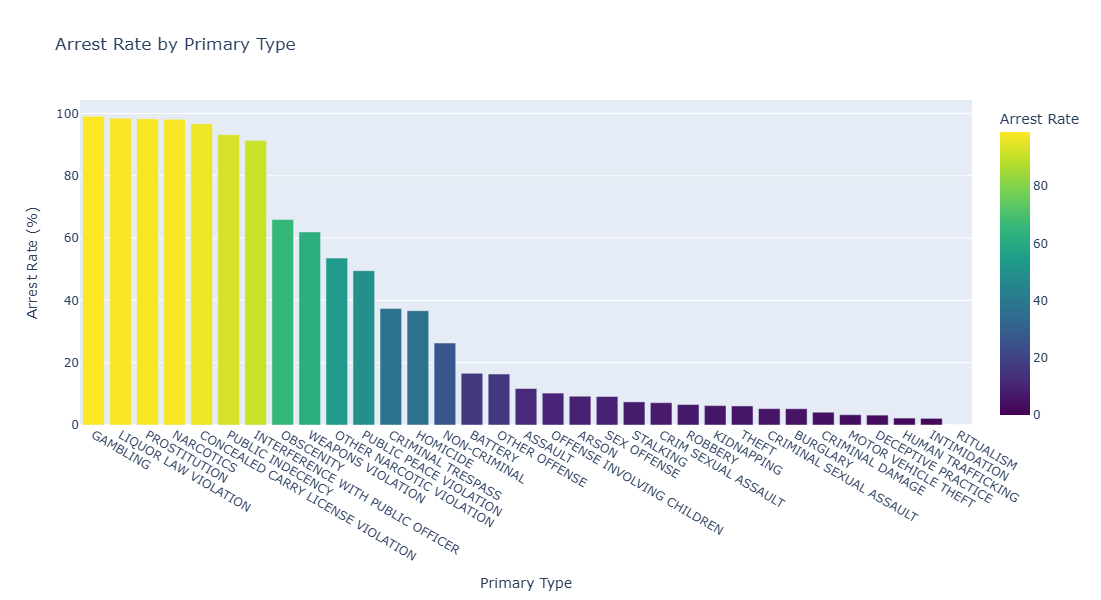

In [32]:
arrest_trend = crime_df.groupby('primary_type')['arrest_rate_by_primary_type'].mean().round(2)
arrest_trend = arrest_trend.reset_index()
arrest_trend.columns = ['Primary Type', 'Arrest Rate']

# Create the bar chart
fig = px.bar(
    arrest_trend,
    x='Primary Type',
    y='Arrest Rate',
    title="Arrest Rate by Primary Type",
    labels={'Primary Type': 'Arrest Rate (%)', 'Primary Type': 'Primary Type'},
    color='Arrest Rate',  # Color by arrest rate for a gradient effect
    color_continuous_scale='Viridis'   # Choose a color scale (optional)
)

# Update layout for better readability
fig.update_layout(
    xaxis={'categoryorder':'total descending'},  # Sort communities by arrest rate
    xaxis_title="Primary Type",
    yaxis_title="Arrest Rate (%)",
    height=600,
    width=1000
)

# Show the chart
fig.show()